In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import matplotlib

import ydata_profiling
from ydata_profiling.utils.cache import cache_file

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale


In [2]:
#Load vehicle fuel type data for years 2018-2022 into pandas

vd22 = pd.read_csv('vehicle_fuel_type_2022.csv')
vd21 = pd.read_csv('vehicle_fuel_type_2021.csv')
vd20 = pd.read_csv('vehicle_fuel_type_2020.csv')
vd19 = pd.read_csv('vehicle_fuel_type_2019.csv')
vd18 = pd.read_csv('vehicle_fuel_type_2018.csv')

/var/folders/b6/_m6td1sj1gx6y7djysg9kvjr0000gn/T/ipykernel_28207/1550789048.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  vd22 = pd.read_csv('vehicle_fuel_type_2022.csv')
/var/folders/b6/_m6td1sj1gx6y7djysg9kvjr0000gn/T/ipykernel_28207/1550789048.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  vd21 = pd.read_csv('vehicle_fuel_type_2021.csv')
/var/folders/b6/_m6td1sj1gx6y7djysg9kvjr0000gn/T/ipykernel_28207/1550789048.py:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  vd20 = pd.read_csv('vehicle_fuel_type_2020.csv')
/var/folders/b6/_m6td1sj1gx6y7djysg9kvjr0000gn/T/ipykernel_28207/1550789048.py:6: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  vd19 = pd.read_csv('vehicle_fuel_type_2019.csv')
/var/folders/b6/_m6td1sj1gx6y7djysg9kvjr0000gn/T/ipykernel_28207/155

In [3]:
#Quick look at data
vd22.head(20)

,Date,Zip Code,Model Year,Fuel,Make,Duty,Vehicles
0,12/31/2022,90000,2010,Gasoline,OTHER/UNK,Light,1
1,12/31/2022,90000,2012,Hybrid Gasoline,OTHER/UNK,Light,1
2,12/31/2022,90000,2013,Gasoline,OTHER/UNK,Light,1
3,12/31/2022,90000,<2009,Gasoline,OTHER/UNK,Heavy,19
4,12/31/2022,90000,<2009,Gasoline,OTHER/UNK,Light,16
5,12/31/2022,90000,<2009,Gasoline,OTHER/UNK,Unk,7
6,12/31/2022,90000,<2009,Gasoline,FORD,Light,19
7,12/31/2022,90000,<2009,Gasoline,PLYMOUTH,Light,35
8,12/31/2022,90000,<2009,Gasoline,CHEVROLET,Light,20
9,12/31/2022,90000,<2009,Unk,OTHER/UNK,Unk,21


In [4]:
#Create list of our files to combine
#2018 data not used because partial data (was tabulated in October of 2018 and not at end of the year)
frames = [vd22,vd21,vd20,vd19]

In [5]:
#Vertically concat all vehicle fuel data into one DataFrame

vehicle_data = pd.concat(frames)

In [6]:
vehicle_data.columns

Index(['Date', 'Zip Code', 'Model Year', 'Fuel', 'Make', 'Duty', 'Vehicles'], dtype='object')

In [7]:
vehicle_data.shape

(2769882, 7)

In [8]:
#Create ydata profile report 

report = vehicle_data.profile_report(
    sort=None, html={"style": {"full_width": True}}, progress_bar=False
)
report

In [9]:
#No duplicate rows 
vehicle_data[vehicle_data.duplicated() == True]

,Date,Zip Code,Model Year,Fuel,Make,Duty,Vehicles


In [10]:
# All types of Fuel; no additional values or None is good
vehicle_data['Fuel'].unique()

array(['Gasoline', 'Hybrid Gasoline', 'Unk', 'Diesel and Diesel Hybrid',
       'Flex-Fuel', 'Natural Gas', 'Battery Electric', 'Plug-in Hybrid',
       'Other', 'Hydrogen Fuel Cell'], dtype=object)

In [11]:
#Small number of rows for 'OOS' so we can drop these from the data
vehicle_data['Zip Code'].value_counts()

OOS      6308
95747    3231
95762    2923
95828    2833
95691    2758
         ... 
94385       1
94364       1
94360       1
94351       1
94286       1
Name: Zip Code, Length: 9923, dtype: int64

In [12]:
#Verify that we have 9923 unique zipcodes
len(vehicle_data['Zip Code'].unique())

9923

In [13]:
oos = np.where(vehicle_data['Zip Code'].unique() == 'OOS')
oos

(array([4897]),)

In [14]:
vehicle_data[vehicle_data['Zip Code'] == 'OOS'].value_counts()

Date        Zip Code  Model Year  Fuel                      Make       Duty   Vehicles
1/1/2020    OOS       2007        Diesel and Diesel Hybrid  CHEVROLET  Heavy  70          1
1/1/2022    OOS       2020        Plug-in Hybrid            FORD       Light  23          1
                                                            BMW        Light  16          1
                                  Natural Gas               VOLVO      Heavy  11          1
                                                            PETERBILT  Heavy  18          1
                                                                                         ..
1/1/2021    OOS       2015        Gasoline                  RAM        Heavy  75          1
                                                            PORSCHE    Light  34          1
                                                            OTHER/UNK  Unk    9           1
                                                                       Light  16     

In [15]:
#Drop all rows where zip code is 'OOS'
vehicle_data.drop(vehicle_data[vehicle_data['Zip Code'] == 'OOS'].index, inplace = True)

In [16]:
#Large number of vehicles are Unknown so we will drop this column
vehicle_data.value_counts('Duty')

Duty
Light    2142840
Heavy     311812
Unk       298761
dtype: int64

In [17]:
#Large number of vehicles make are Unknown so we will drop this column as well
vehicle_data.value_counts('Make')

Make
OTHER/UNK           1098351
TOYOTA               171683
FORD                 170465
CHEVROLET            129571
HONDA                106602
                     ...   
GREENPOWER MOTOR          2
TEMSA                     1
SEAGRAVE                  1
CROWN COACH INC           1
ORANGE EV                 1
Length: 133, dtype: int64

In [18]:
#Dropping columns for Model Year (ambiguous data), Make (majority is unknown due to non-random bias)
# and Duty (majority are Light)

vehicle_data.drop(['Model Year', 'Make', 'Duty'], axis = 1, inplace = True)

In [19]:
#Verify columns have been dropped
vehicle_data.columns

Index(['Date', 'Zip Code', 'Fuel', 'Vehicles'], dtype='object')

In [20]:
vehicle_data.groupby(['Zip Code','Fuel'])
vehicle_data.head(10)

,Date,Zip Code,Fuel,Vehicles
0,12/31/2022,90000,Gasoline,1
1,12/31/2022,90000,Hybrid Gasoline,1
2,12/31/2022,90000,Gasoline,1
3,12/31/2022,90000,Gasoline,19
4,12/31/2022,90000,Gasoline,16
5,12/31/2022,90000,Gasoline,7
6,12/31/2022,90000,Gasoline,19
7,12/31/2022,90000,Gasoline,35
8,12/31/2022,90000,Gasoline,20
9,12/31/2022,90000,Unk,21


In [21]:
#Verify that we only have one date for each year of data --> verified this is true
vehicle_data['Date'].unique()

array(['12/31/2022', '1/1/2022', '1/1/2021', '1/1/2020'], dtype=object)

In [22]:
#Create lists so we can map current date column into a new Year column

yr_values = ['2022','2021','2020','2019','2018']
yr_conditions = [(vehicle_data['Date'] == '12/31/2022'),
                 (vehicle_data['Date'] == '1/1/2022'),
                 (vehicle_data['Date'] == '1/1/2021'),
                 (vehicle_data['Date'] == '1/1/2020'),
                 (vehicle_data['Date'] == '10/1/2018')
                ]

In [23]:
#Create new Year column
vehicle_data['Year'] = np.select(yr_conditions,yr_values)

In [24]:
vehicle_data.value_counts('Date')

Date
12/31/2022    760746
1/1/2022      717941
1/1/2021      675099
1/1/2020      599627
dtype: int64

In [25]:
#Verify that we have identical values for dates and years
vehicle_data.value_counts('Year')

Year
2022    760746
2021    717941
2020    675099
2019    599627
dtype: int64

In [26]:
vehicle_group = vehicle_data.groupby(['Zip Code', 'Year','Fuel'], as_index=False)['Vehicles'].sum()

In [27]:
type(vehicle_group)

pandas.core.frame.DataFrame

In [28]:
vehicle_group

,Zip Code,Year,Fuel,Vehicles
0,90000,2021,Diesel and Diesel Hybrid,37
1,90000,2021,Gasoline,182
2,90000,2021,Other,6
3,90000,2022,Diesel and Diesel Hybrid,36
4,90000,2022,Gasoline,118
...,...,...,...,...
87042,99990,2022,Diesel and Diesel Hybrid,1
87043,99999,2019,Gasoline,5
87044,99999,2020,Gasoline,7
87045,99999,2021,Gasoline,5


In [29]:
vehicle_group.describe()

,Vehicles
count,87047.000000
mean,1376.576252
std,5644.497025
min,1.000000
25%,3.000000
50%,23.000000
75%,371.000000
max,116659.000000


In [30]:
#Sanity check high max number ---> this is for populous LA county so it is reasonable
vehicle_group[vehicle_group['Vehicles'] == 116659]

,Zip Code,Year,Fuel,Vehicles
805,90045,2021,Gasoline,116659


In [31]:
# Need to create column shows vehicle as percent of total vehicles in the zipcode
temp = vehicle_group.groupby(['Zip Code','Year'],as_index=False)['Vehicles'].sum()

In [32]:
# This gives how many total vehicles in a given zip code in a given year
temp

,Zip Code,Year,Vehicles
0,90000,2021,225
1,90000,2022,321
2,90001,2021,35507
3,90001,2022,35045
4,90002,2021,31389
...,...,...,...
20461,99990,2022,1
20462,99999,2019,5
20463,99999,2020,7
20464,99999,2021,5


In [33]:
#Combine vehicles total into a new column
vehicles_total = pd.merge(vehicle_group,temp,on = ['Zip Code', 'Year'],how = 'inner')

In [34]:
vehicles_total.head(10)

,Zip Code,Year,Fuel,Vehicles_x,Vehicles_y
0,90000,2021,Diesel and Diesel Hybrid,37,225
1,90000,2021,Gasoline,182,225
2,90000,2021,Other,6,225
3,90000,2022,Diesel and Diesel Hybrid,36,321
4,90000,2022,Gasoline,118,321
5,90000,2022,Hybrid Gasoline,1,321
6,90000,2022,Unk,166,321
7,90001,2021,Battery Electric,52,35507
8,90001,2021,Diesel and Diesel Hybrid,813,35507
9,90001,2021,Flex-Fuel,1329,35507


In [35]:
#Rename column to Vehicles Total
vehicles_total.rename({'Vehicles_x': 'Vehicles', 'Vehicles_y': 'Vehicles Total'}, axis=1, inplace=True)

In [36]:
vehicles_total

,Zip Code,Year,Fuel,Vehicles,Vehicles Total
0,90000,2021,Diesel and Diesel Hybrid,37,225
1,90000,2021,Gasoline,182,225
2,90000,2021,Other,6,225
3,90000,2022,Diesel and Diesel Hybrid,36,321
4,90000,2022,Gasoline,118,321
...,...,...,...,...,...
87042,99990,2022,Diesel and Diesel Hybrid,1,1
87043,99999,2019,Gasoline,5,5
87044,99999,2020,Gasoline,7,7
87045,99999,2021,Gasoline,5,5


In [37]:
#Create new column that shows ratio of each fuel type to total vehicles registered in a given zip code in a given year

vehicles_total['Vehicle Ratio'] = vehicles_total['Vehicles']/vehicles_total['Vehicles Total']

In [38]:
vehicles_total

,Zip Code,Year,Fuel,Vehicles,Vehicles Total,Vehicle Ratio
0,90000,2021,Diesel and Diesel Hybrid,37,225,0.164444
1,90000,2021,Gasoline,182,225,0.808889
2,90000,2021,Other,6,225,0.026667
3,90000,2022,Diesel and Diesel Hybrid,36,321,0.112150
4,90000,2022,Gasoline,118,321,0.367601
...,...,...,...,...,...,...
87042,99990,2022,Diesel and Diesel Hybrid,1,1,1.000000
87043,99999,2019,Gasoline,5,5,1.000000
87044,99999,2020,Gasoline,7,7,1.000000
87045,99999,2021,Gasoline,5,5,1.000000


<Axes: xlabel='Year', ylabel='Vehicle Ratio'>

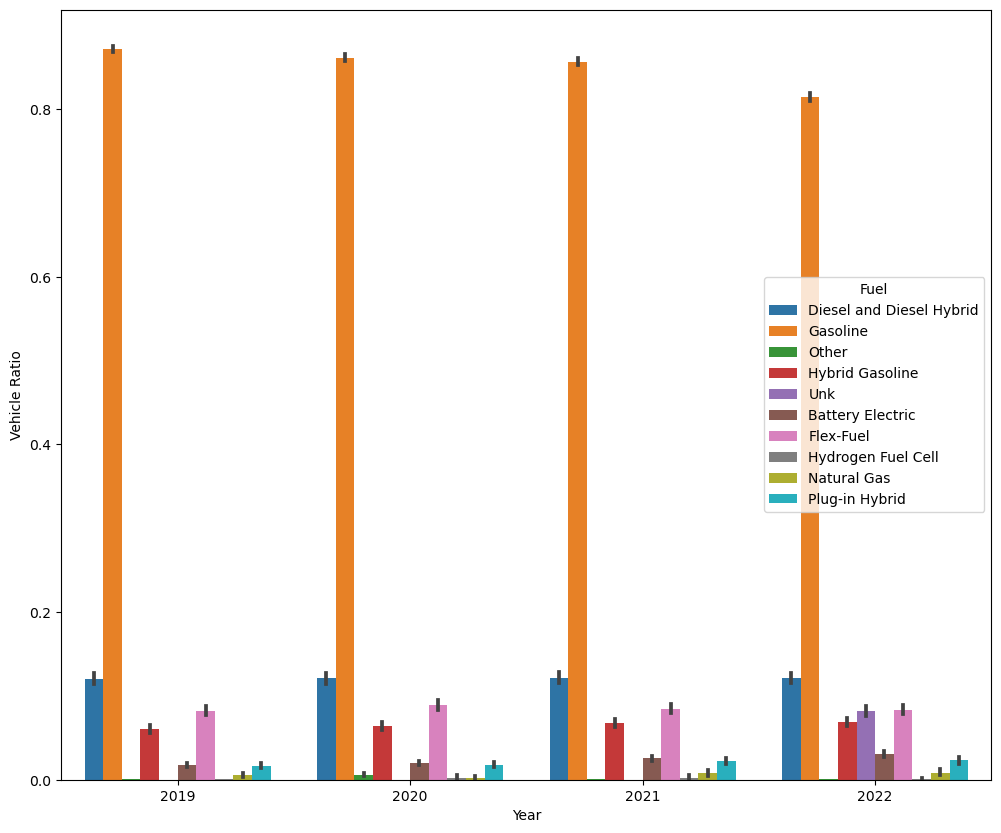

In [39]:
#Create plot of vehicle ratio by fuel type for each year
#Plot shows decline in gasoline and increase in others (ie. Battery Electric)

plt.subplots(figsize=(12, 10))
fig = sns.barplot(x='Year', y='Vehicle Ratio', hue='Fuel', data=vehicles_total, saturation=0.8, order = ['2019','2020','2021','2022'])
fig

In [40]:
#Load income data into pandas

income_data = pd.read_csv('Personal_Income_By_Zip_Code.csv')

In [41]:
income_data.head()

,Taxable Year,Zip Code,State,City,County,Returns,CA AGI,Total Tax Liability,CountyLatitude,CountyLongitude,Geo County,Geo City,Geo ZipCode
0,2020,92137,CA,San Diego,San Diego,188,38663083,3084980,32.789640,-117.193658,POINT (-117.1936577 32.78964014),POINT (-117.16171 32.71568),NaN
1,2020,94557,CA,Hayward,Alameda,107,5104485,159000,37.720226,-122.164352,POINT (-122.1643521 37.72022591),POINT (-122.08556 37.67134),NaN
2,2020,93005,CA,Ventura,Ventura,227,16117556,899344,34.277091,-119.217850,POINT (-119.2178496 34.27709072),POINT (-119.29232 34.28082),NaN
3,2020,93227,CA,Goshen,Tulare,354,23665658,1764599,36.282543,-118.265210,POINT (-118.2652098 36.28254312),POINT (-85.83695 41.58918),NaN
4,2020,93523,CA,Edwards,Kern,693,30550251,907583,35.376768,-118.807357,POINT (-118.8073572 35.37676773),POINT (-117.93907 34.92778),POINT (-117.93907 34.92778)


In [42]:
income_data.columns

Index(['Taxable Year', 'Zip Code', 'State', 'City', 'County', 'Returns',
       'CA AGI', 'Total Tax Liability', 'CountyLatitude', 'CountyLongitude',
       'Geo County', 'Geo City', 'Geo ZipCode'],
      dtype='object')

In [43]:
#Dropping all irrelevant columns
income_data.drop(['CountyLatitude','CountyLongitude','Geo County','Geo City','Geo ZipCode','State','Total Tax Liability'],axis = 1, inplace = True)

In [44]:
income_data

,Taxable Year,Zip Code,City,County,Returns,CA AGI
0,2020,92137,San Diego,San Diego,188,38663083
1,2020,94557,Hayward,Alameda,107,5104485
2,2020,93005,Ventura,Ventura,227,16117556
3,2020,93227,Goshen,Tulare,354,23665658
4,2020,93523,Edwards,Kern,693,30550251
...,...,...,...,...,...,...
68583,1998,95009,CampBell,Santa Clara,402,18980130
68584,1995,92375,Redlands,San Bernardino,521,32684197
68585,1995,95812,Sacramento,Sacramento,553,18338511
68586,1997,91786,Upland,San Bernardino,17749,591798095


In [45]:
#Create ydata profile report 

report = income_data.profile_report(
    sort=None, html={"style": {"full_width": True}}, progress_bar=False
)
report

In [46]:
#Create new column that calculates average income by CA AGI/ Returns
#Should not have negtive values here...
income_data['AGI_calc'] = income_data['CA AGI']/income_data['Returns']
income_data['AGI_calc'].describe().apply(lambda x: format(x, 'f'))

count        68588.000000
mean         84794.976858
std        1149859.726985
min       -2215751.908840
25%          32796.716898
50%          44771.562544
75%          64082.769974
max      191436550.900000
Name: AGI_calc, dtype: object

In [47]:
#Negative values for AGI appear incorrect, unsure if simply should be positive or other issue; we will drop these
income_data[income_data['CA AGI'] < 0]

,Taxable Year,Zip Code,City,County,Returns,CA AGI,AGI_calc
37,2014,94522,Concord,Contra Costa,345,-49626037,-143843.585507
305,2014,95655,Mather,Sacramento,1711,-513046636,-299851.920514
330,2018,93102,Santa Barbara,Santa Barbara,444,-51736031,-116522.592342
397,2015,93102,Santa Barbara,Santa Barbara,532,-36862664,-69290.721805
490,2011,93448,Pismo Beach,San Luis Obispo,844,-3531740,-4184.526066
...,...,...,...,...,...,...,...
65973,1995,95387,Westley,Stanislaus,624,-22076075,-35378.325321
66949,1996,94519,Concord,Contra Costa,7773,-280796572,-36124.607230
67243,1996,96088,Shingletown,Shasta,1425,-923929270,-648371.417544
67919,1995,92160,San Diego,San Diego,210,-11919865,-56761.261905


In [48]:
#Check if any negative values in Returns
income_data[income_data['Returns'] < 0]

,Taxable Year,Zip Code,City,County,Returns,CA AGI,AGI_calc


In [49]:
#Drop all rows with negative values in CA AGI 
income_data.drop(income_data[income_data['CA AGI'] < 0].index, inplace = True)

In [50]:
#Verify they have been dropped
income_data[income_data['CA AGI'] < 0]

,Taxable Year,Zip Code,City,County,Returns,CA AGI,AGI_calc


In [51]:
#Create new column that calculates average income by CA AGI/ Returns
income_data['AGI_calc'] = income_data['CA AGI']/income_data['Returns']
income_data['AGI_calc'].describe().apply(lambda x: format(x, 'f'))

count        68360.000000
mean         85437.307111
std        1151613.738268
min             10.037613
25%          32917.423368
50%          44855.570412
75%          64169.719225
max      191436550.900000
Name: AGI_calc, dtype: object

In [52]:
#These values seem very high but with small sample size, unsure if incorrect or plausible
income_data[income_data['AGI_calc'] > 50000000]

,Taxable Year,Zip Code,City,County,Returns,CA AGI,AGI_calc
224,2010,92633,Fullerton,Orange,17,1898690834,1.116877e+08
4848,2010,94125,San Francisco,San Francisco,46,2701523468,5.872877e+07
6568,2010,93064,Brandeis,Ventura,29,1563018131,5.389718e+07
7894,2010,92521,Riverside,Riverside,12,637162348,5.309686e+07
11533,2010,94527,Concord,Contra Costa,10,1914365509,1.914366e+08
13720,2010,93019,Null,Null,3,279936667,9.331222e+07
19035,2010,91521,Burbank,Los Angeles,10,680091634,6.800916e+07


In [53]:
income_data.dtypes

Taxable Year      int64
Zip Code         object
City             object
County           object
Returns           int64
CA AGI            int64
AGI_calc        float64
dtype: object

In [54]:
vehicles_total.dtypes

Zip Code           object
Year               object
Fuel               object
Vehicles            int64
Vehicles Total      int64
Vehicle Ratio     float64
dtype: object

In [55]:
#Rename column
income_data.rename({'Taxable Year': 'Year'}, axis=1, inplace=True)

In [56]:
vehicles_total['Year'] = vehicles_total['Year'].astype(int)

In [57]:
#Merge vehicle data with income data using inner join on Year and Zip Code

df = pd.merge(vehicles_total,income_data,how = 'inner', on = ['Year','Zip Code'])

In [58]:
df

,Zip Code,Year,Fuel,Vehicles,Vehicles Total,Vehicle Ratio,City,County,Returns,CA AGI,AGI_calc
0,90001,2019,Battery Electric,21,34608,0.000607,Los Angeles,Los Angeles,21515,704531451,32746.05861
1,90001,2019,Diesel and Diesel Hybrid,804,34608,0.023232,Los Angeles,Los Angeles,21515,704531451,32746.05861
2,90001,2019,Flex-Fuel,1247,34608,0.036032,Los Angeles,Los Angeles,21515,704531451,32746.05861
3,90001,2019,Gasoline,31934,34608,0.922735,Los Angeles,Los Angeles,21515,704531451,32746.05861
4,90001,2019,Hybrid Gasoline,531,34608,0.015343,Los Angeles,Los Angeles,21515,704531451,32746.05861
...,...,...,...,...,...,...,...,...,...,...,...
33133,96162,2020,Battery Electric,1,1179,0.000848,Truckee,Nevada,1167,93932710,80490.75407
33134,96162,2020,Diesel and Diesel Hybrid,88,1179,0.074640,Truckee,Nevada,1167,93932710,80490.75407
33135,96162,2020,Flex-Fuel,44,1179,0.037320,Truckee,Nevada,1167,93932710,80490.75407
33136,96162,2020,Gasoline,1027,1179,0.871077,Truckee,Nevada,1167,93932710,80490.75407


In [59]:
df.describe()

,Year,Vehicles,Vehicles Total,Vehicle Ratio,Returns,CA AGI,AGI_calc
count,33138.000000,33138.000000,33138.00000,33138.000000,33138.000000,3.313800e+04,3.313800e+04
mean,2019.508812,1787.756443,15243.46240,0.141831,9356.949484,8.521242e+08,9.625490e+04
std,0.499930,6446.593563,16709.18329,0.283795,10250.252069,1.188481e+09,1.381089e+05
min,2019.000000,1.000000,2.00000,0.000014,1.000000,1.203000e+03,8.020000e+01
25%,2019.000000,7.000000,744.00000,0.002972,473.000000,3.204307e+07,4.848359e+04
50%,2020.000000,66.000000,9238.00000,0.021538,5336.000000,3.894221e+08,6.651158e+04
75%,2020.000000,540.000000,26188.00000,0.060578,16425.000000,1.267526e+09,9.931871e+04
max,2020.000000,115852.000000,128465.00000,1.000000,49466.000000,1.280332e+10,6.030052e+06
